In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as pty
from PIL import Image
import torch
from torchvision import datasets, transforms
import helper
import cv2
import seaborn as sns
import os
from pathlib import Path
print(os.listdir("/content/drive/MyDrive/AQC"))
from collections import defaultdict

['train_images', 'test_images', 'sample_submission.csv', 'train.csv']


In [5]:
# Data path
TRAIN_IMG_PATH = "/content/drive/MyDrive/AQC/train_images/"
TEST_IMG_PATH = "/content/drive/MyDrive/AQC/test_images/"
TRAIN_DF_PATH = "/content/drive/MyDrive/AQC/train.csv"

In [6]:
# Total number of training Images and testing images
print("Total number of training images:")
print(len([entry for entry in os.listdir(TRAIN_IMG_PATH) if os.path.isfile(os.path.join(TRAIN_IMG_PATH, entry))]))

Total number of training images:
12568


In [7]:
print("Total number of testing images:")
print(len([entry for entry in os.listdir(TEST_IMG_PATH) if os.path.isfile(os.path.join(TEST_IMG_PATH, entry))]))

Total number of testing images:
5006


In [8]:
# Load Data
train_df = pd.read_csv(TRAIN_DF_PATH)

In [9]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [10]:
train_df.shape

(7095, 3)

In [11]:
train_df.describe()

,ClassId
count,7095.000000
mean,2.825229
std,0.789279
min,1.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,4.000000


In [12]:
def without_hue(ax, feature):
    total = float(sum(feature))
    for p in ax.patches:
        print(p.get_height)
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        ax.annotate(percentage, (x, y), size = 12, ha='center')

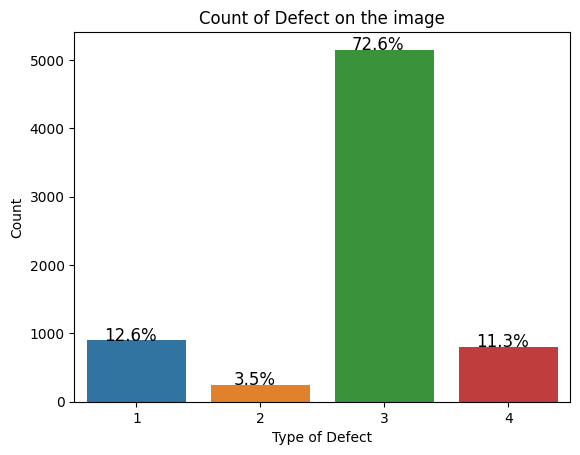

In [13]:
# Type of defects in the image
def_img_df = train_df.groupby(["ClassId"])['ImageId'].count().reset_index()
ax = sns.barplot(data=def_img_df, x="ClassId", y="ImageId")
#ax.bar_label(ax.containers[0])
total = float(sum(def_img_df.ImageId))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), size = 12, ha='center')
ax.set(xlabel='Type of Defect', ylabel='Count', title = "Count of Defect on the image")
plt.show()

* Around 3/4 of the steel bar images has the defect of "type 3" and 'type 2" Defect is seen least in our training data sample.

We will look if the same images have multiple class of defects or not.

In [14]:
# Checking the number of defects in images
defect_count = train_df.ImageId.value_counts().reset_index().groupby(["ImageId"])['index'].count().reset_index()

In [15]:
defect_count

,ImageId,index
0,1,6239
1,2,425
2,3,2


We know the total number of training images is 12568. From above code we have only found the details about the images which have atleast one defect which is given in the dataframe.

In [16]:
12568 - sum(defect_count['index'])

5902

5902 are not available in the train_df which means these images has no defects.

In [17]:
# For finding the number of images which does not have defect
file_names = []
for root, dirs, files in os.walk(TRAIN_IMG_PATH):
    # Print the file names
    for file in files:
        file_names.append(os.path.join(root, file))
        #print(os.path.join(root, file))

In [18]:
img_name_df = pd.DataFrame(file_names, columns = ["img_name"])
img_name_df.head()

,img_name
0,/content/drive/MyDrive/AQC/train_images/eb0c5c...
1,/content/drive/MyDrive/AQC/train_images/ebfa0c...
2,/content/drive/MyDrive/AQC/train_images/ebcfa7...
3,/content/drive/MyDrive/AQC/train_images/eaebc5...
4,/content/drive/MyDrive/AQC/train_images/eb81be...


In [19]:
# Extract the last 13 character string
img_name_df['Image_Id'] = img_name_df['img_name'].str[-13:]

In [20]:
img_name_df

,img_name,Image_Id
0,/content/drive/MyDrive/AQC/train_images/eb0c5c...,eb0c5c725.jpg
1,/content/drive/MyDrive/AQC/train_images/ebfa0c...,ebfa0cc57.jpg
2,/content/drive/MyDrive/AQC/train_images/ebcfa7...,ebcfa79fd.jpg
3,/content/drive/MyDrive/AQC/train_images/eaebc5...,eaebc549c.jpg
4,/content/drive/MyDrive/AQC/train_images/eb81be...,eb81bea67.jpg
...,...,...
12563,/content/drive/MyDrive/AQC/train_images/0a76c7...,0a76c7934.jpg
12564,/content/drive/MyDrive/AQC/train_images/0cd22b...,0cd22bad5.jpg
12565,/content/drive/MyDrive/AQC/train_images/0bfcf7...,0bfcf7a71.jpg
12566,/content/drive/MyDrive/AQC/train_images/0d01c8...,0d01c8efb.jpg


In [21]:
defect_dict = {}

for i in range(12568):
    img_name_df.iloc[i][1]
    defect_value = train_df[train_df.ImageId == img_name_df.iloc[i][1]].shape[0]
    defect_dict.setdefault(defect_value, 0)
    defect_dict[defect_value] += 1

In [22]:
defect_dict

{0: 5902, 1: 6239, 2: 425, 3: 2}

In [23]:
defect_df = pd.DataFrame(list(defect_dict.items()), columns=['defect_no','count'])

In [24]:
defect_df

,defect_no,count
0,0,5902
1,1,6239
2,2,425
3,3,2


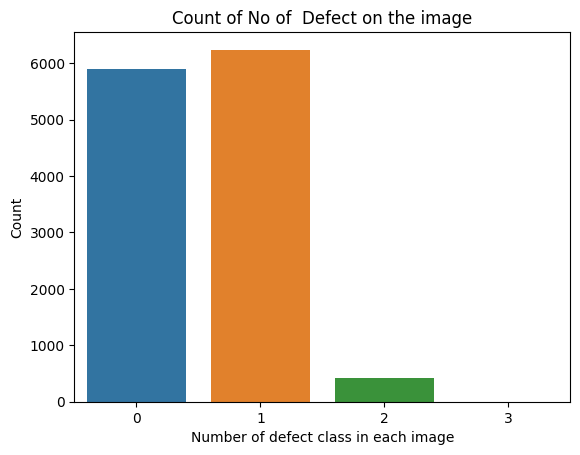

In [25]:
ax = sns.barplot(data=defect_df, x="defect_no", y="count")
#ax.bar_label(ax.containers[0])
ax.set(xlabel='Number of defect class in each image', ylabel='Count', title = "Count of No of  Defect on the image")
plt.show()

Almost half of the images has no defect in the training samples. Must of the image with defect have only one defect class.

In [26]:
img_dft_dict = {}
for i in range(len(train_df['ImageId'])):
    #print(train_df.iloc[i][0])
    img_name = train_df.iloc[i][0]
    img_dft_dict.setdefault(img_name,[])
    if img_name in img_dft_dict:
    #Details["Age"].append("Twenty")
        img_dft_dict[img_name].append(train_df.iloc[i][1])

In [27]:
print(len(img_dft_dict))

6666


In [28]:
img_dft_df = pd.DataFrame(list(img_dft_dict.items()), columns=['image_id','defect_typ'])

In [29]:
img_dft_df.head()

,image_id,defect_typ
0,0002cc93b.jpg,[1]
1,0007a71bf.jpg,[3]
2,000a4bcdd.jpg,[1]
3,000f6bf48.jpg,[4]
4,0014fce06.jpg,[3]


In [30]:
img_dft_df['length'] = img_dft_df['defect_typ'].str.len()

In [31]:
img_dft_df.sort_values(by='length',ascending=False)

,image_id,defect_typ,length
6253,ef24da2ba.jpg,"[1, 2, 3]",3
5740,db4867ee8.jpg,"[1, 2, 3]",3
3435,84865746c.jpg,"[3, 4]",2
2203,5665ada1b.jpg,"[3, 4]",2
6149,eb44ad79d.jpg,"[3, 4]",2
...,...,...,...
2280,59ce36e8a.jpg,[3],1
2279,59c00ad1f.jpg,[3],1
2278,59bcf1693.jpg,[3],1
2277,59bc9997f.jpg,[3],1


In [32]:
img_dft_df = img_dft_df.astype({'defect_typ':'string'})

In [33]:
img_dft_df = img_dft_df.groupby(['defect_typ'])['image_id'].count().reset_index().sort_values(by='image_id')

In [34]:
img_dft_df

,defect_typ,image_id
5,"[2, 4]",1
0,"[1, 2, 3]",2
4,"[2, 3]",14
1,"[1, 2]",35
2,"[1, 3]",91
6,[2],195
7,"[3, 4]",284
9,[4],516
3,[1],769
8,[3],4759


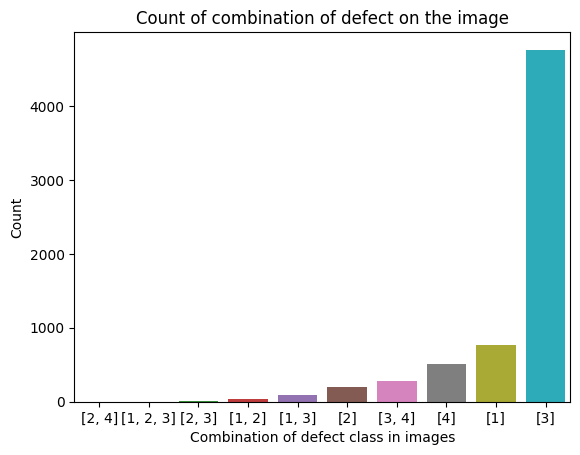

In [35]:
ax = sns.barplot(data=img_dft_df, x="defect_typ", y="image_id")
#ax.bar_label(ax.containers[0])
ax.set(xlabel='Combination of defect class in images', ylabel='Count', title = "Count of combination of defect on the image")
plt.show()